## Building a model

In [1]:
%autosave 5

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation

Autosaving every 5 seconds


In [2]:
# period_length is the size of the period to use as training input.
# Here I am using a 7-day period to predict a week in the future. 
period_length = 7

# number_of_periods is the number of periods used as training input.
# There are 77 weeks available in our dataset. 
# The very last week is used to test the LSTM network on every epoch, so here i am using 76 periods to train it.
number_of_periods = 76

In [3]:
def build_model(period_length, number_of_periods, batch_size=1):
    """Build an LSTM model using Keras.

    Parameters
    ----------
    period_length: int
        The size of each observation used as input.

    number_of_periods: int
        The number of periods available in the
        dataset.

    batch_size: int
        The size of the batch used in each training
        period.

    Returns
    -------
    model: Keras model
        Compiled Keras model that can be trained
        and stored in disk.
    """
    model = Sequential()
    model.add(LSTM(
        units=period_length,
        batch_input_shape=(batch_size, number_of_periods, period_length),
        input_shape=(number_of_periods, period_length),
        return_sequences=False, stateful=False))

    model.add(Dense(units=period_length))
    model.add(Activation("linear"))

    model.compile(loss="mse", optimizer="rmsprop")

    return model

## Saving the model

In [4]:
model = build_model(period_length=period_length, number_of_periods=number_of_periods)
model.save('bitcoin_lstm_v0.h5')

In [5]:
%autosave 5

#  Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

from keras.models import load_model

Autosaving every 5 seconds


In [6]:
#  Import training dataset
train = pd.read_csv('data/train_dataset.csv')
train.head()

,date,iso_week,close,volume,close_point_relative_normalization,volume_point_relative_normalization
0,2016-01-01,2016-00,434.33,36278900.0,0.000000,0.000000
1,2016-01-02,2016-00,433.44,30096600.0,-0.002049,-0.170410
2,2016-01-03,2016-01,430.01,39633800.0,0.000000,0.000000
3,2016-01-04,2016-01,433.09,38477500.0,0.007163,-0.029175
4,2016-01-05,2016-01,431.96,34522600.0,0.004535,-0.128961


## Load the model

In [7]:
model = load_model('bitcoin_lstm_v0.h5')

## Reshape data

In [8]:
def create_groups(data, group_size=7):
    """Create distinct groups from a continuous series.
    
    Parameters
    ----------
    data: np.array
        Series of continious observations.

    group_size: int, default 7
        Determines how large the groups are. That is,
        how many observations each group contains.
    
    Returns
    -------
    A Numpy array object. 
    """
    samples = []
    for i in range(0, len(data), group_size):
        sample = list(data[i:i + group_size])
        if len(sample) == group_size:
            samples.append(np.array(sample).reshape(1, group_size))
    
    return np.array(samples)

In [9]:
#  Find the remainder when the number of observations is divided by group size
len(train) % 7

2

In [10]:
#  Creating groups of 7 from our data.
#  We drop the first two observations so that the
#  number of total observations is divisible by the `group_size`.
data = create_groups(train['close_point_relative_normalization'][2:].values)
print(data.shape)

(77, 1, 7)


In [11]:
#  Reshape data into format expected by LSTM layer
X_train = data[:-1, :].reshape(1, 76, 7)
Y_validation = data[-1].reshape(1, 7)
print(X_train.shape)
print(Y_validation.shape)

(1, 76, 7)
(1, 7)


## Train the model

In [12]:
%%time
#  Train the model
history = model.fit(
    x=X_train, y=Y_validation,
    batch_size=32, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 2/100
1/1 [==============================] - 0s 993us/step - loss: 0.0033
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 11/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 12/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 13/100
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 1ms/step - loss: 2.2237e-06
CPU times: user 6.05 s, sys: 520 ms, total: 6.57 s
Wall time: 6.25 s


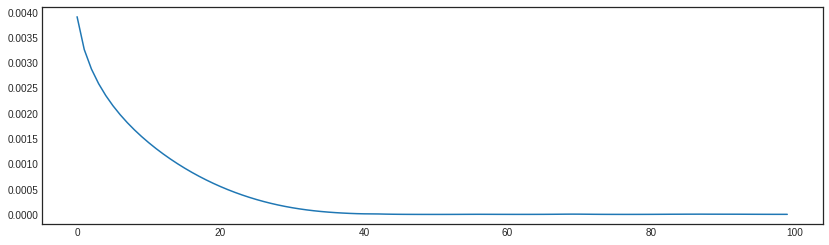

In [13]:
#  Plotting loss function
pd.Series(history.history['loss']).plot(figsize=(14, 4));

## Making predictions

In [14]:
#  Make predictions using X_train data
predictions = model.predict(x=X_train)[0]
predictions

array([-0.00152344,  0.01557525,  0.0656655 ,  0.05613946,  0.06082529,
        0.07926988,  0.02534248], dtype=float32)

In [15]:
def denormalize(series, last_value):
    """Denormalize the values for a given series.
    
    This uses the last value available (i.e. the last
    closing price of the week before our prediction)
    as a reference for scaling the predicted results.
    """
    result = last_value * (series + 1)
    return result

In [16]:
#  Denormalize predictions
last_weeks_value = train[train['date'] == train['date'][:-7].max()]['close'].values[0]

denormalized_prediction = denormalize(predictions, last_weeks_value)
denormalized_prediction

array([2651.8337, 2697.246 , 2830.2795, 2804.9795, 2817.4248, 2866.4111,
       2723.1865], dtype=float32)

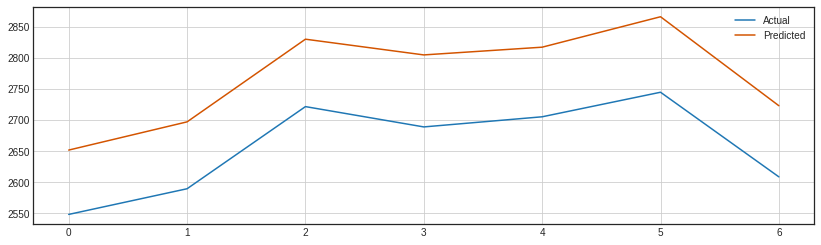

In [17]:
#  Plotting denormalized predictions against actual predictions
plt.figure(figsize=(14, 4))

plt.plot(train['close'][-7:].values, label='Actual')
plt.plot(denormalized_prediction, color='#d35400', label='Predicted')

plt.grid()
plt.legend();

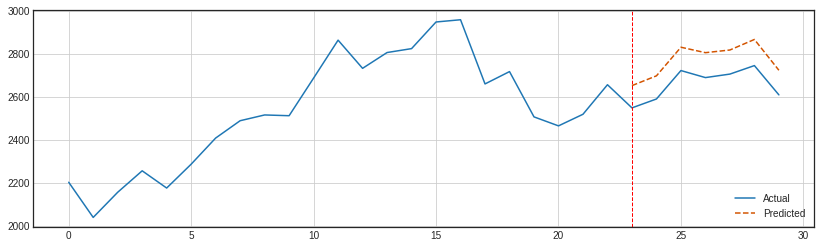

In [18]:
prediction_plot = np.zeros(len(train)-2)
prediction_plot[:] = np.nan
prediction_plot[-7:] = denormalized_prediction

plt.figure(figsize=(14, 4))
plt.plot(train['close'][-30:].values, label='Actual')
plt.plot(prediction_plot[-30:], color='#d35400', linestyle='--', label='Predicted')
plt.axvline(30 - 7, color='r', linestyle='--', linewidth=1)

plt.grid()
plt.legend(loc='lower right');

In [19]:
#  Saving model to the disk
model.save('bitcoin_lstm_v0_trained.h5')